## General idea of Adversarial:

    - When we do it?
        When we have train and test data.
        
    - Why we do it?
        To check if the train and test data have similar distribution.

    - How we do it?
        We concatenate the train and test data and create a binary target keeping train to be 1 and test to be 0. Then we build model on the new combined dataset (do the regular train-test split) to predict this new target.

    - How to interpret results?
        Model performance, here AUC score, is noted. A good model performance is to be interpretted that there is a difference in train and test data.
        
    - Conclusions?
        If the model performs poorly, we need to trust our local model performance. CV-loss if I may.



In [1]:
import pandas as pd
import numpy as np
np.random.random(42)

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc
import lightgbm as lgb

from tqdm import tqdm
import time

import warnings
warnings.filterwarnings("ignore")


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
!pwd

/home/onkardeshpande127/kaggle_santander/code


In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
print(train.shape, test.shape)

(200000, 202) (200000, 201)


In [4]:
print( train.target.value_counts() / train.shape[0] * 100 )

0    89.951
1    10.049
Name: target, dtype: float64


In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


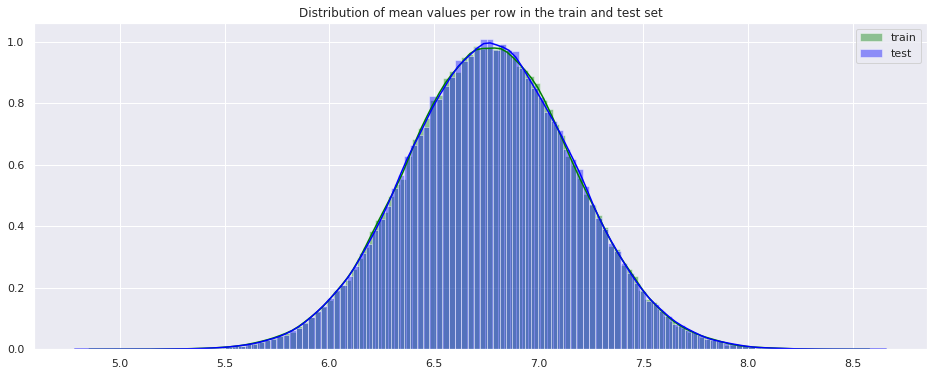

In [6]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

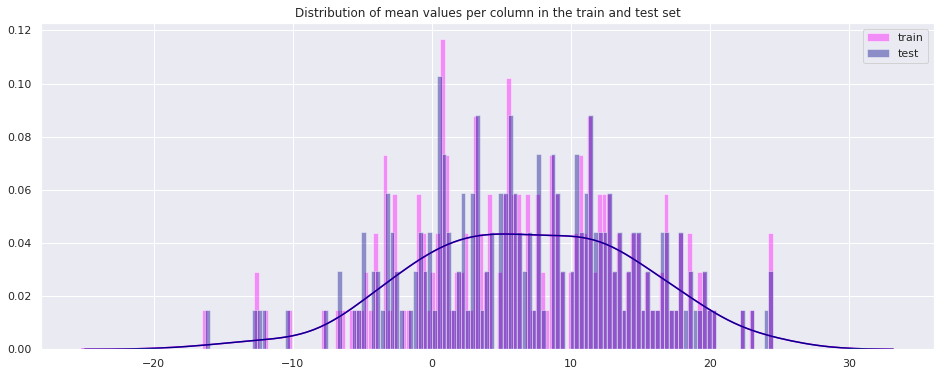

In [7]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

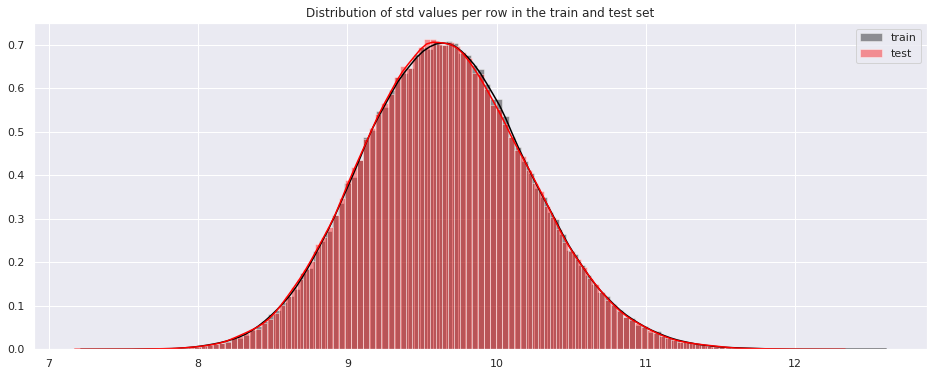

In [8]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

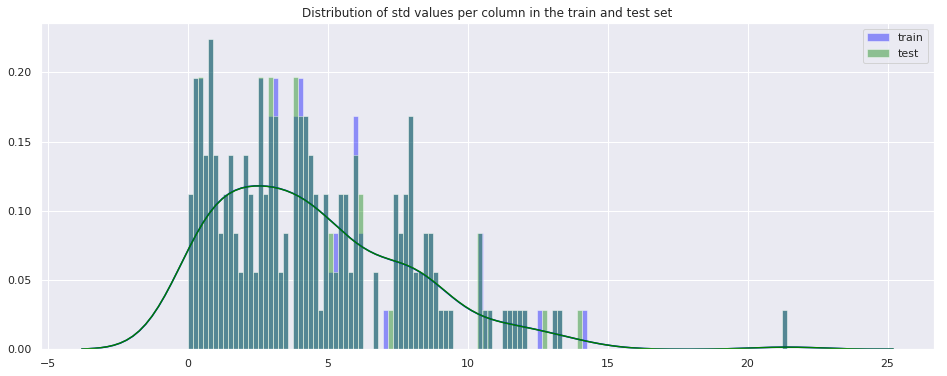

In [9]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

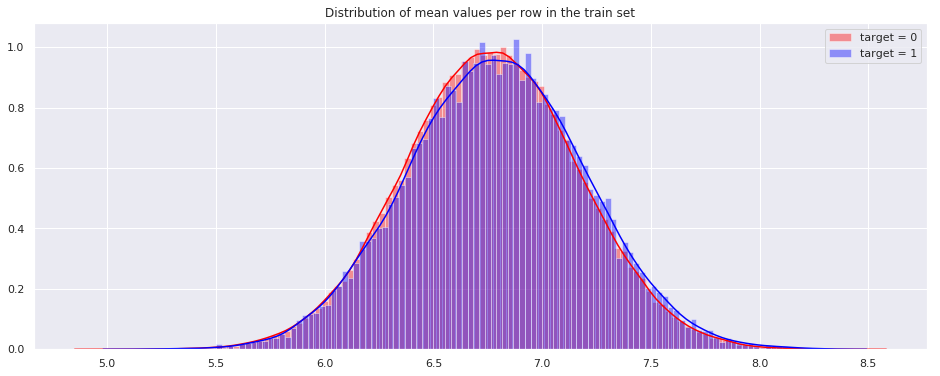

In [11]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

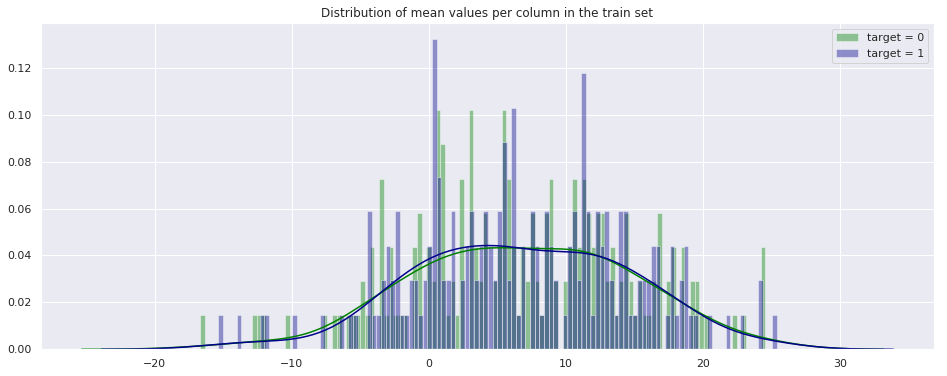

In [12]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

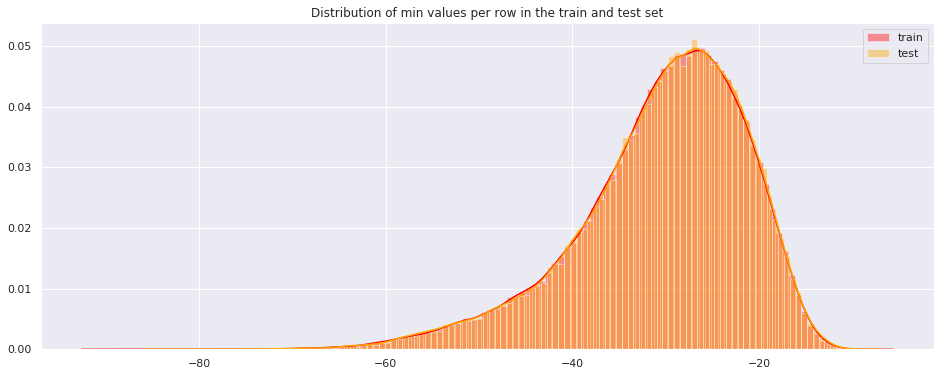

In [13]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

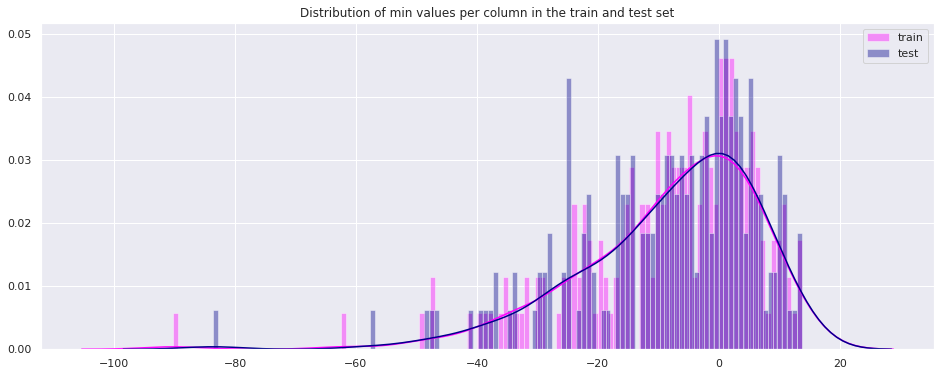

In [14]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

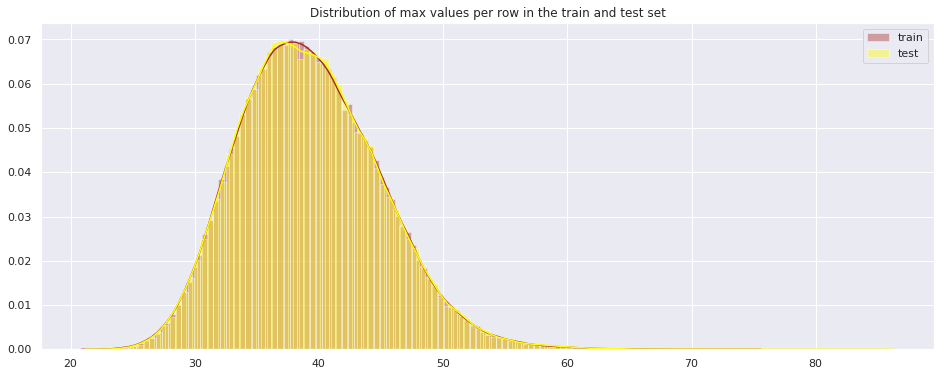

In [15]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

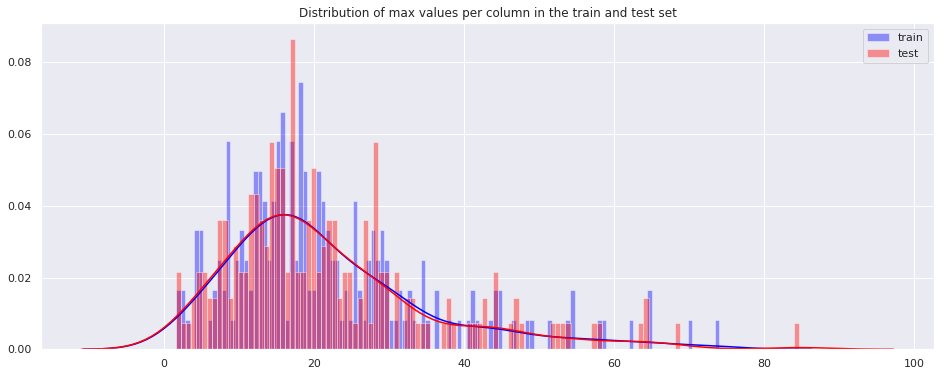

In [16]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

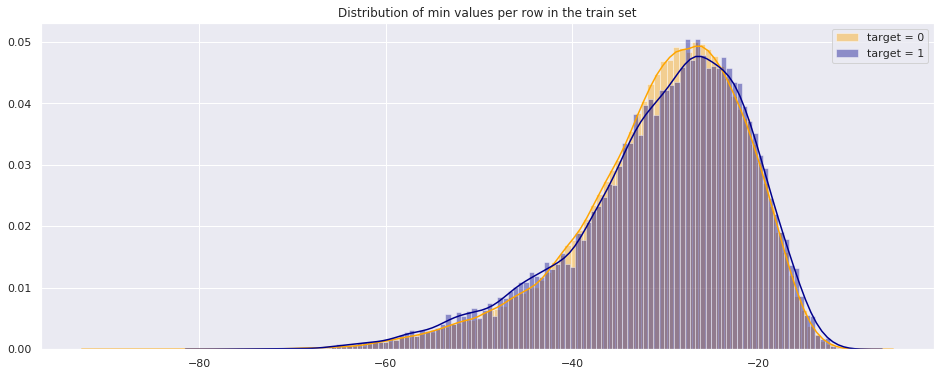

In [18]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

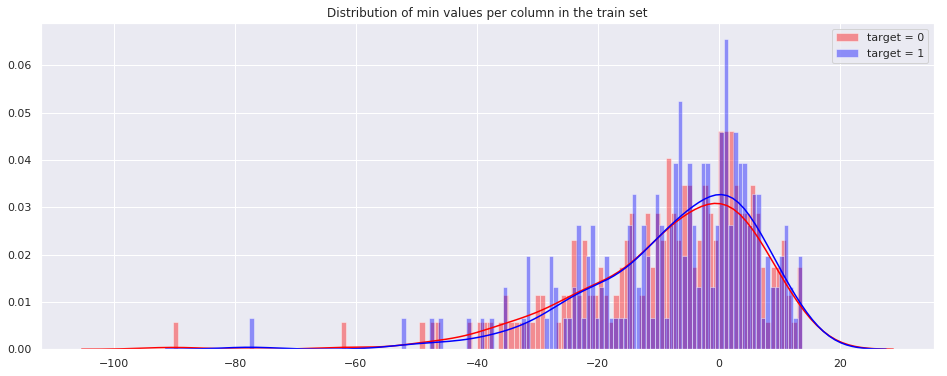

In [19]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

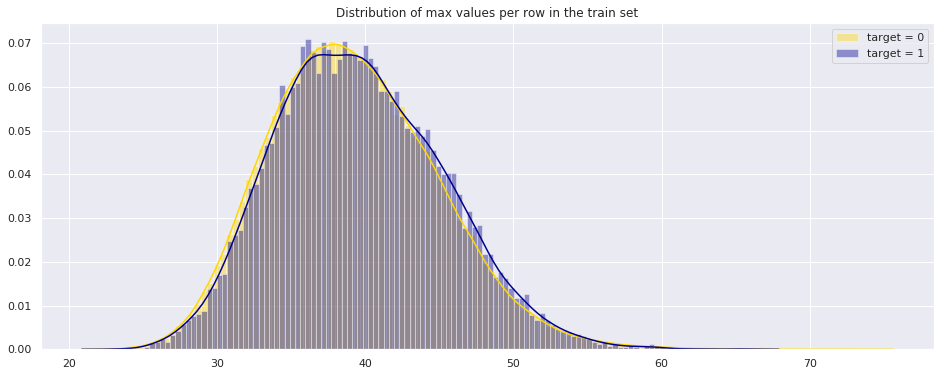

In [20]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

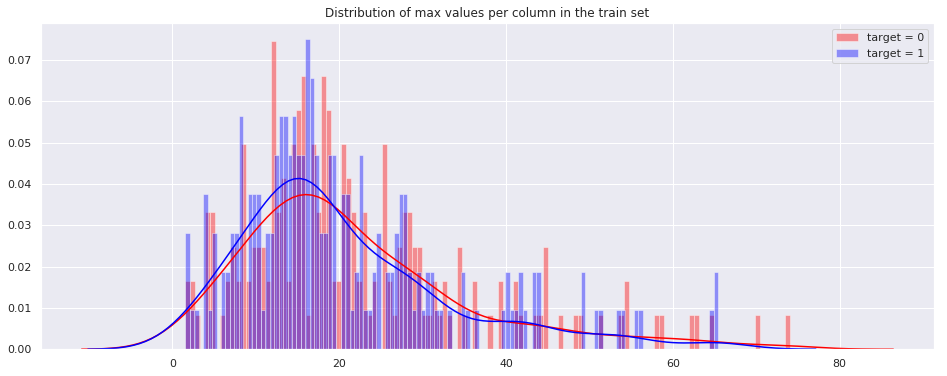

In [21]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

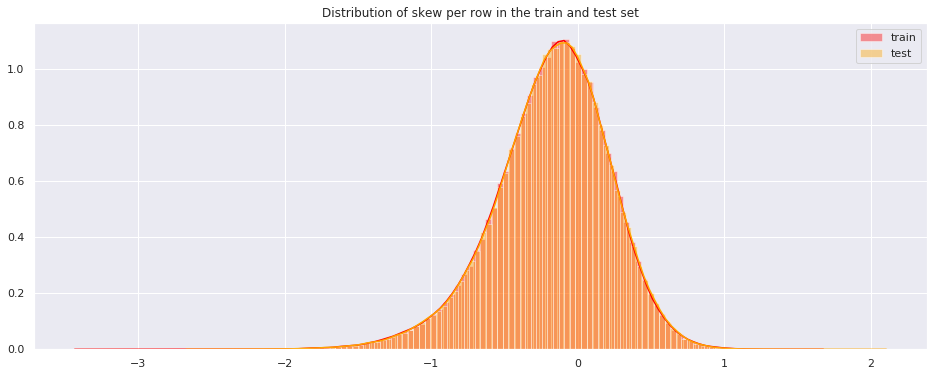

In [22]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

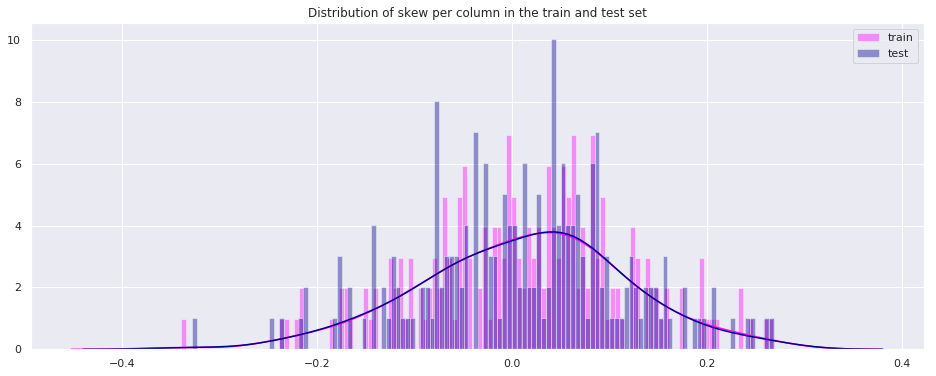

In [23]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

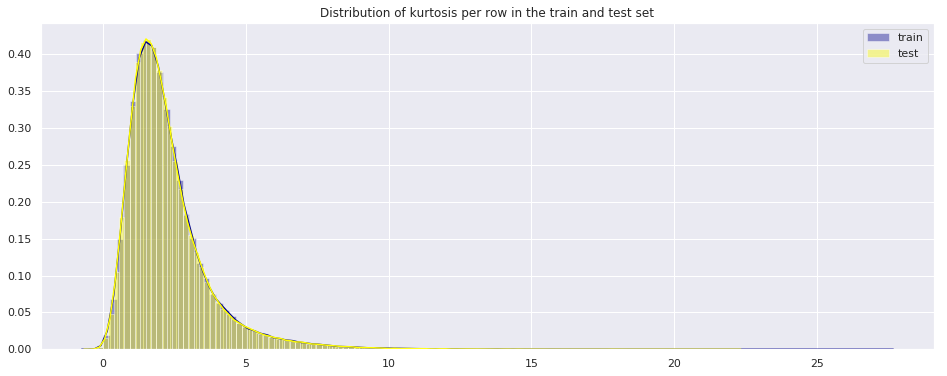

In [24]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

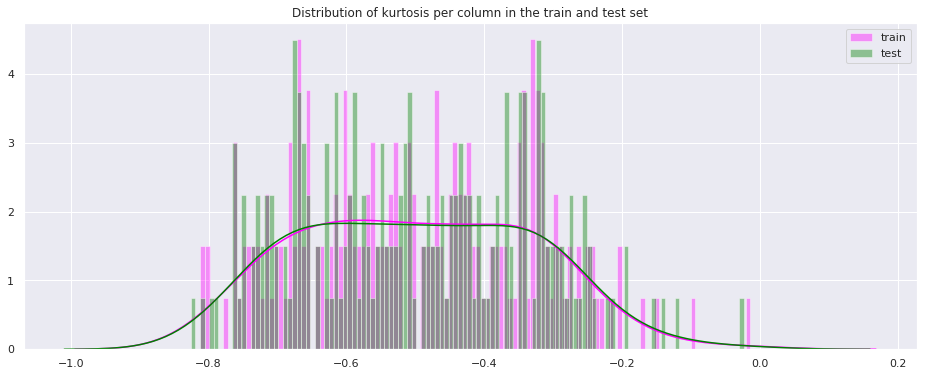

In [25]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

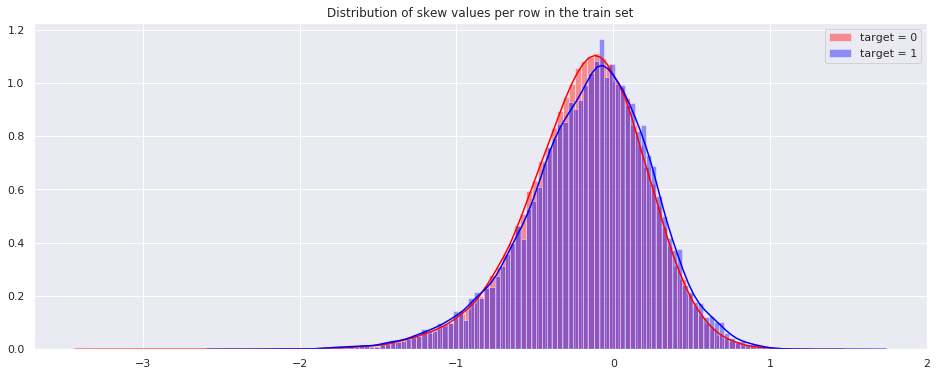

In [26]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

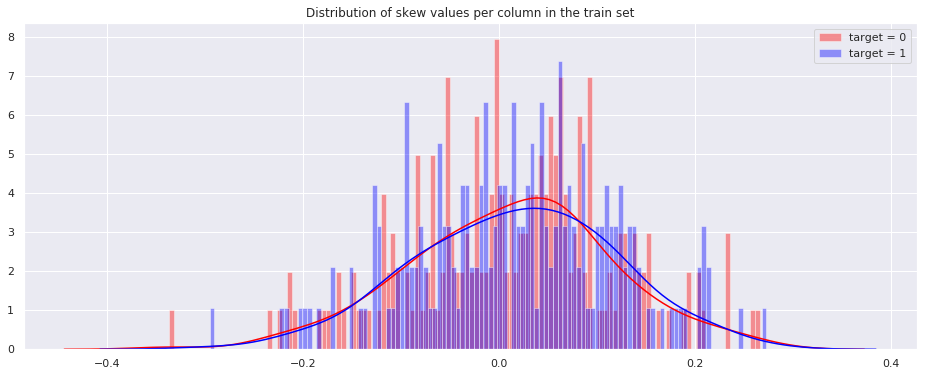

In [27]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

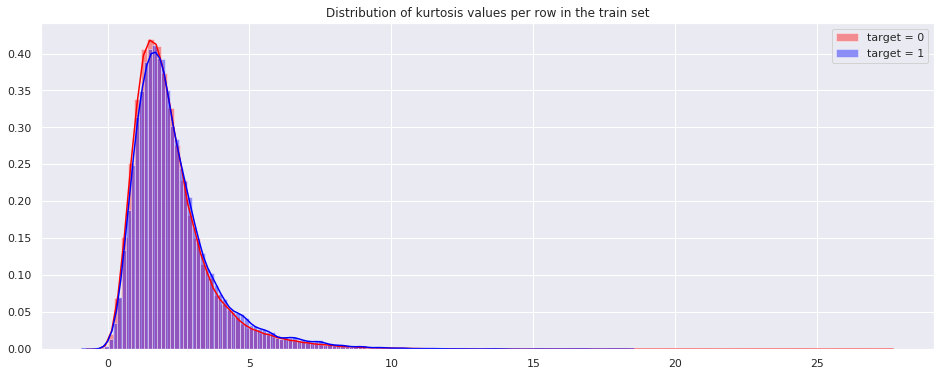

In [28]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

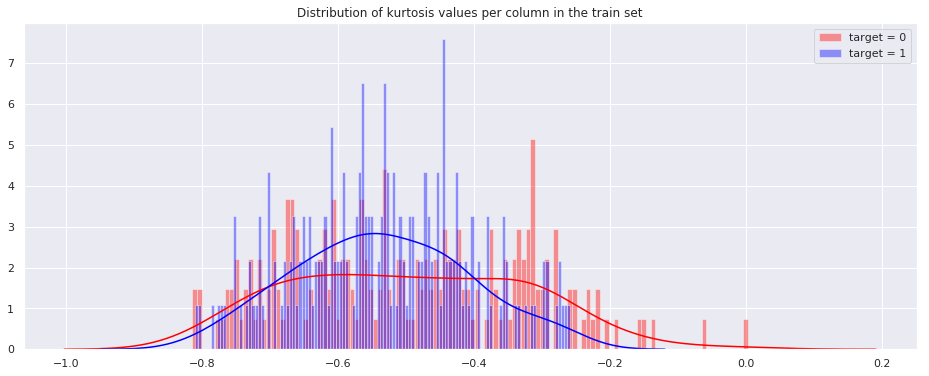

In [29]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

In [6]:
train["train_test"] = 1
test["train_test"] = 0

In [7]:
data = pd.concat((train, test))

y = data.pop('train_test')
x = data.drop( [ 'target', 'ID_code'], axis = 1 )


del train, test, data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [ ]:
## Linear model

In [ ]:
clf = LogisticRegression(penalty="l1", C=0.1, solver="liblinear")

clf.fit(x_train, y_train)
y_pred = clf.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, y_pred)

In [ ]:
## Random forest

In [11]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)


y_pred = clf.predict_proba(x_test)[:, 1]
print("AUC:",round(roc_auc_score(y_test, y_pred)*100,2),"%")

AUC: 49.83 %


In [ ]:
## LGBM model

In [9]:
params = {'num_leaves': 9,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_fraction': 0.8,
         'bagging_seed': 11,
         'reg_alpha': 1.73,
         'reg_lambda': 5,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.011,
         'min_child_weight': 19,
         'num_threads': 4}

In [10]:
%%time
fold_n=3

folds = StratifiedKFold(n_splits=fold_n, shuffle=True)
y_pred_lgb = np.zeros(len(x_test))

for fold_n, (train_index, valid_index) in enumerate(folds.split(x_train, y_train)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
    Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=Y_train)
    valid_data = lgb.Dataset(X_valid, label=Y_valid)
        
    lgb_model = lgb.train(params, train_data, num_boost_round=1000,
                    valid_sets = [train_data, valid_data],verbose_eval=300,early_stopping_rounds = 50)
            
    y_pred_lgb += lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)/3
    
print("AUC:",round(roc_auc_score(y_test, y_pred_lgb)*100,2),"%")

Fold 0 started at Wed Mar  6 00:12:29 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.573547	valid_1's auc: 0.507071
Early stopping, best iteration is:
[357]	training's auc: 0.579695	valid_1's auc: 0.507347
Fold 1 started at Wed Mar  6 00:13:10 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.567701	valid_1's auc: 0.507178
[600]	training's auc: 0.594515	valid_1's auc: 0.507591
[900]	training's auc: 0.615082	valid_1's auc: 0.508242
[1200]	training's auc: 0.632895	valid_1's auc: 0.508948
[1500]	training's auc: 0.648301	valid_1's auc: 0.509181
[1800]	training's auc: 0.661433	valid_1's auc: 0.509299
[2100]	training's auc: 0.673246	valid_1's auc: 0.50972
[2400]	training's auc: 0.684194	valid_1's auc: 0.510057
[2700]	training's auc: 0.694095	valid_1's auc: 0.510494
[3000]	training's auc: 0.703387	valid_1's auc: 0.510756
[3300]	training's auc: 0.711829	valid_1's auc: 0.511221
[3600]	training's auc: 0.719902